# Designing and Altering Hyper-parameters in Neural Networks performed in Pytorch for Maximizing the Accuracy in Image Classification
## Image Classification - Parsa Madinei

## Imports

In [68]:
import random
import numpy as np
import torchvision
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import time
from datetime import timedelta
from datetime import datetime
from sklearn.model_selection import train_test_split

## Part 0 - Before Starting
### Dataset Loading
I used ZIP.id to download dataset to my notebook, and then unzip the main folder.

In [1]:
# !cd './content/gdrive/My Drive/Colab Notebooks/AI-CA5'
!gdown --id "1aFjcSk9hBzsHusrjO3UjCg4xQo9Ubdr1"
!unzip "categorized_products" -d ""

### Transform Images to Gray Scale
The function of class bellow is just transforming images into what is called gray-Scaled images.

In [ ]:
class ToTensor(object):
    """Convert PIL Images in sample to pytorch Tensors."""
    
    def __call__(self, image):
        image = np.array(image,dtype=np.float32)
        # numpy image: H x W
        return torch.from_numpy(image)

## Part 1 - Image visualization

In cell bellow, I transform dataset into "ToTensor", plus indicating the classes in dataset and the number of batch_size to start.

In [69]:
transform = transforms.Compose( [transforms.Grayscale() , ToTensor()] )
dataset = ImageFolder( root="./categorized_products" , transform=transform)
classes = dataset.classes
batch_size = 64

And the "imshow" function, displays images in given labels and classes, "make_unique_images" makes uniques cattegories so that I can display each product without repeating ourselves, and lastly, I execute these functions.

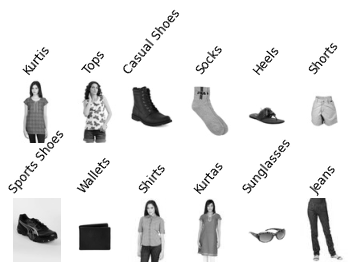

In [ ]:
def imshow(img_array, labels, classes):
    _, axs = plt.subplots(2,6)
    for i in range(2):
      for j in range(6):
        axs[i][j].imshow(img_array[i * 6 + j], cmap='gray')
        axs[i][j].set_title(classes[labels[i * 6 + j]],rotation=50)
        axs[i][j].axis('off')
    plt.show()

def make_unique_images(labels,classes):
  unique_labels = []
  unique_images = []
  added_classes = []
  for i in range(len(labels)):
    if classes[labels[i]] not in added_classes:
      unique_labels.append(labels[i])
      unique_images.append(images[i])
      added_classes.append(classes[labels[i]])
  return unique_labels,unique_images

data_sampler = SubsetRandomSampler(range(len(dataset)))
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=data_sampler, num_workers=16)
data_iter = iter(data_loader)
data_iter.next()
images, labels = data_iter.next()

unique_la, unique_im = make_unique_images(labels,classes)
imshow(unique_im[0:12], unique_la[0:12], classes)

## Part 2 - Bar Plot & Train_Test_Split

### A - Bar Plot
The "plot_distribution" function takes the data_loader and classes, and uses "draw_plot" to plot the amount of images from each class. <br>

In [ ]:
def draw_plot(plot_info):
    to_plot = {k: v for k, v in sorted(plot_info.items(), key=lambda item: item[1])}
    plt.figure(figsize=(20,10))
    plt.xlabel('Product Type')
    plt.ylabel('Number of Pictures')
    plt.bar(list(to_plot.keys())[::-1],list(to_plot.values())[::-1],0.2)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

def plot_distribution(loader, classes):
    total_category_count = {classes[i] : 0 for i in range(len(classes))}
    for _, labels in loader:
        for label in labels:
            total_category_count[ classes[label] ] += 1
    to_plot = {}
    for category in classes:
        to_plot[category] = total_category_count[category]
    draw_plot(to_plot)

It clearly indicates that our dataset is not even-distributed (not even close to it!). The diffrence between Tshirts and cufflinks is more than 3000 sample images for instance.

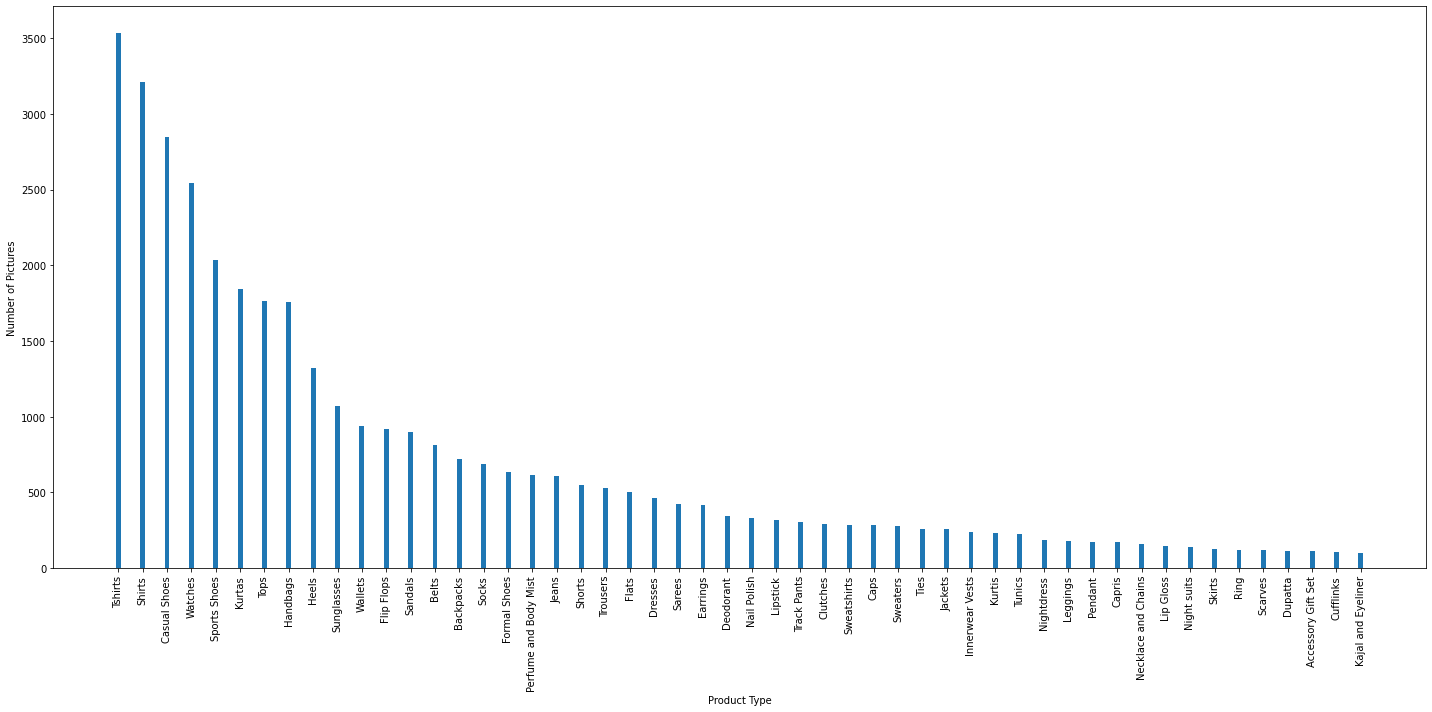

In [ ]:
plot_distribution(data_loader, classes)

### B - Train_Test_split
I used sklearn's "train_test_split" built-in function with the option "stratify" is equal to sorted values of targets of dataset, in the pursuit of splitting each class separately.

In [76]:
to_arange = dataset.targets
to_arange.sort()

# split the dataset into train and test sets randomly with split of 0.2 and assign their indices in the original set to train_indices and test_indices 
train_indicer, test_indicer = train_test_split(np.arange(len(to_arange)), test_size= 0.2, shuffle=True, stratify=to_arange)

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indicer)
test_sampler = SubsetRandomSampler(test_indicer)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=16)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=16)

And for being sure about the successful splitting, I draw our bar plot to show that the shape of the bars and the arrangement of each category haven't had any changes.

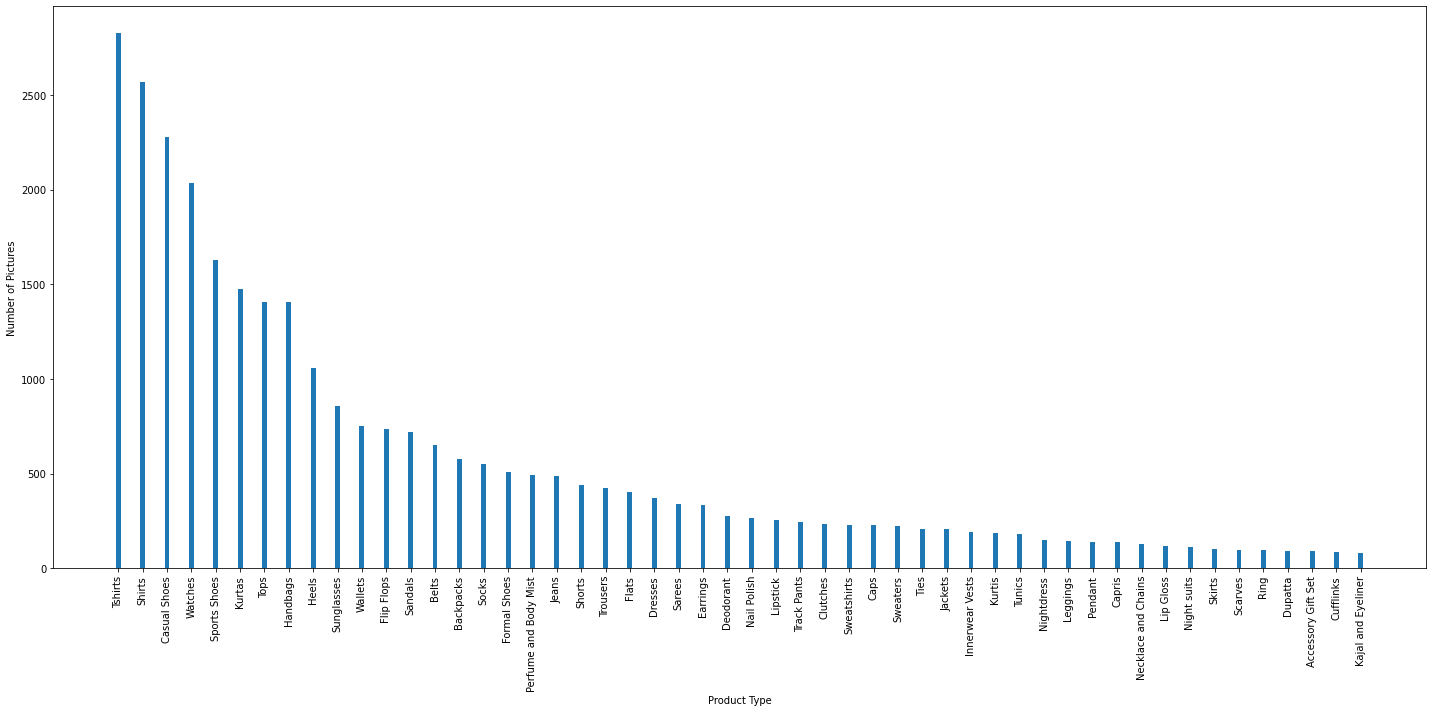

In [ ]:
plot_distribution(train_loader, classes)

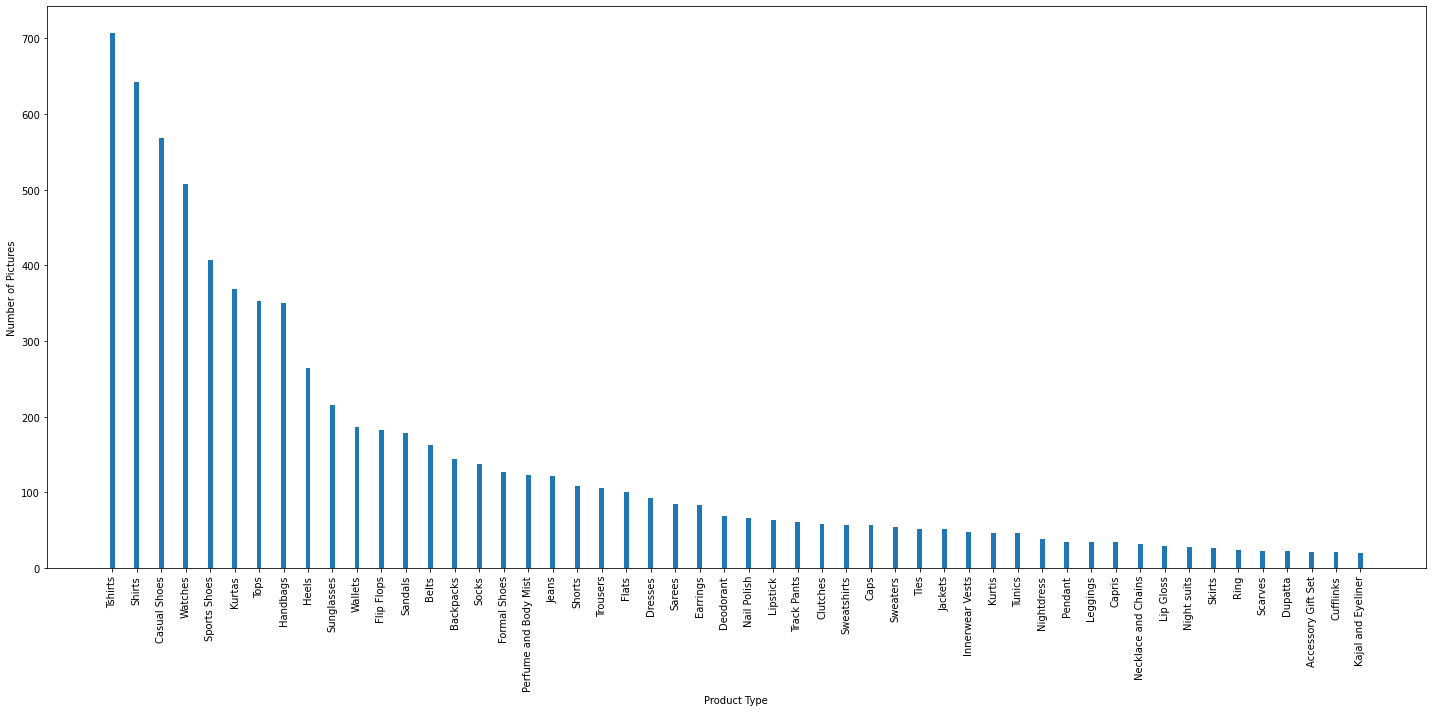

In [ ]:
plot_distribution(test_loader, classes)

## Part 3 - Model Creation and Fitting
### A - Model Creation & summary
I build our Model class in the way that it could inherits nn.Module from PyTorch. At the beginning, the pre assumptions are:<br> batch_size = 64<br>num_of_epochs = 10<br>learning rate = 0.01<br>activation_functions = relu<br><br>
I also concluded from many trials that one input layer, 5 hidden layers, and one softmax output layer could end up with better results. I used 4800 neurons for first layer and give them to first hidden layer with 4000 neurons, then I devided number of neurons to 2 through the other hidden layers in the pursuit of decreasing the layers to 52, which is the number of categories.<br><br> I should concider that adding too many more hidden layers can easily lead us to overfitting point, and adding lower number of hidden layers will increase the computing time with no huge diffrence to the accuracy. <br><br>
Other than that, by using "start_weights" function, I set the weight of Linear layers into the constant that I give to the model (for part 5). <br>Also I set the biases to Zero.

In [ ]:
class Model(nn.Module):
    def __init__(self, class_num, act=F.relu):

        super(Model, self).__init__()

        self.layer1 = nn.Linear(1 * 60 * 80, 4000)
        self.act1 = act

        self.layer2 = nn.Linear(4000, 2000)
        self.act2 = act


        self.layer3 = nn.Linear(2000, 1000)
        self.act3 = act

        self.layer4 = nn.Linear(1000, 500)
        self.act4 = act

        self.layer5 = nn.Linear(500, 250)
        self.act5 = act

        self.layer6 = nn.Linear(250, class_num)

    def forward(self, x):

        x = x.view(x.size(0), -1)
        #Make it one-dimentional

        x = self.layer1(x)
        x = self.act1(x)

        x = self.layer2(x)
        x = self.act2(x)

        x = self.layer3(x)
        x = self.act3(x)

        x = self.layer4(x)
        x = self.act4(x)

        x = self.layer5(x)
        x = self.act5(x)

        x = self.layer6(x)
        return x

    
    def start_weights(self, constant):
  
        nn.init.constant_(self.layer1.weight, constant)
        self.layer1.bias.data.fill_(0)

        nn.init.constant_(self.layer2.weight, constant)
        self.layer2.bias.data.fill_(0)

        nn.init.constant_(self.layer3.weight, constant)
        self.layer3.bias.data.fill_(0)

        nn.init.constant_(self.layer4.weight, constant)
        self.layer4.bias.data.fill_(0)

        nn.init.constant_(self.layer5.weight, constant)
        self.layer5.bias.data.fill_(0)

        nn.init.constant_(self.layer6.weight, constant)
        self.layer6.bias.data.fill_(0)

### preleminary Functions:
Lets make our Preliminary functions before starting to fit the model and tunning hyper parameters.<br><br> fit -> I give the function our model, train_loader, device to run on that, convergence criterion, our optimizer, and the number of epochs wich has been set on 10 by default. At the end of each epoch, it calculates the average loss for each trial and prints it with the total amount of time. <br>For the use of the function "plot_loss_changes" per epoch, I save a tuple of "loss,epoch" for each epoch and return it for the use of mentioned function.

In [ ]:
def fit(model, train_loader, device, criterion, optimizer, num_epochs=10):

  total_time = 0.

  # For the use of the function "plot_loss_changes" 
  loss_epoch = []

  for epoch in range(num_epochs):
      train_loss = 0.
      d1 = datetime.now()
      for images, labels in train_loader:
          
        #Go to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        # images = images.view(1, -1)
        outputs = model(images.float())

        # Calculate Loss: softmax --> cross entropy loss
        # loss here is a tensor
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters with back propagation
        loss.backward()

        # Updating parameters
        optimizer.step()
        train_loss += loss.item()

      # statistics
      average_loss = train_loss / len(train_loader)

      loss_epoch.append(tuple([average_loss,epoch + 1]))

      d2 = datetime.now()
      delta = d2 - d1
      seconds = float(delta.total_seconds())
      total_time += seconds
      print('epoch %d, train_loss: %.3f, time elapsed: %s seconds' % (epoch + 1, average_loss, seconds))
  print('total training time: %.3f minutes' % (total_time / 60))
  return loss_epoch

accuracy_finder -> we give the model and data(loader) to the function and it will predict data and calculate the accuracy of whole data.

class_accuracy -> like the accuracy finder, it generates predictions and returns a list of accuracies (in length of 52 items) for each category.

In [ ]:
def model_accuracy(model, data_loader):
    # Calculate Accuracy         
    correct = 0.
    total = 0.
    # Iterate through test dataset
    with torch.no_grad():
      for images, labels in data_loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cpu') == labels).sum().item()
    accuracy = 100 * correct / total
    print('Accuracy: {}%'.format(accuracy))
    return accuracy

def class_accuracy(model, data_loader):
  # Calculate Accuracies        
    correct_preds_class = [0.] * 52
    total_preds_class = [0.] * 52
    accuracies_class = [0.] * 52
    # Iterate through test dataset
    with torch.no_grad():
      for images, labels in data_loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        is_lable = (predicted.to('cpu') == labels)
        for i in range(len(images)):
            total_preds_class[labels[i]] += 1
            if is_lable[i] == True:
              correct_preds_class[labels[i]] += 1
    for i in range(52):
      accuracies_class[i] = correct_preds_class[i]/total_preds_class[i]
    return accuracies_class

plot_accuracies -> it plots train and test accuracies for each category in one plot by recieving two list of accuracies and name of categories.

In [ ]:
def plot_train_test_accuracies(trains,tests,labels):
  fig = plt.figure(figsize=(110,5),frameon=False)
  plt.xlabel('Product Type')
  plt.ylabel('Accuracy')
  ax = fig.subplots()
  ax.bar(np.arange(len(labels)) - 0.1, trains , 0.2 , label='Train' , color='red')
  ax.bar(np.arange(len(labels)) + 0.1, tests , 0.2 , label='Test' , color='blue')
  ax.set_xticks(np.arange(len(labels)))
  ax.set_xticklabels(labels,rotation=90)
  ax.set_title("Accuracy for each category (train + test)")
  ax.legend()

plot_loss_changes -> it measures average loss for each number of epochs.

In [ ]:
def plot_loss_changes(loss_epoch):
  plt.figure(figsize=(20,10))
  plt.title("Loss / Number of Epochs")
  plt.plot(loss_epoch[0],loss_epoch[1],label = "Loss / Number of Epochs",)
  plt.ylabel('Loss')
  plt.xlabel('Number of Epochs')
  plt.legend()
  plt.show()

And finally, lets make sure that I use GPU to start fitting:

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#so we have GPU running

cuda:0


Firstly, we make and move the model to the device, and then we can see a summary of our model:

In [ ]:
model = Model(len(classes))

model = model.to(device)

The summary clearly indicates the random weights and biases for each layer. As we can see, first layers have much more weights and biases because of huge number of neurons, and as we go along with further layers, we can see less of these numbers. <br> Also the values are very low at the beginning because we don't expect from our model to prematurely thinks a node has lots of influence... if it has, just increase the weight (or bias).

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

layer1.weight tensor([[-0.0085, -0.0066, -0.0014,  ...,  0.0073, -0.0127,  0.0059],
        [-0.0009, -0.0003, -0.0040,  ...,  0.0025,  0.0014,  0.0065],
        [-0.0141, -0.0056,  0.0124,  ..., -0.0113, -0.0096, -0.0127],
        ...,
        [-0.0075, -0.0103, -0.0086,  ...,  0.0141, -0.0122, -0.0021],
        [ 0.0052, -0.0094, -0.0139,  ..., -0.0105, -0.0092,  0.0063],
        [-0.0001,  0.0136, -0.0088,  ...,  0.0117, -0.0094, -0.0055]],
       device='cuda:0')
layer1.bias tensor([-0.0035, -0.0070,  0.0100,  ..., -0.0034, -0.0068,  0.0061],
       device='cuda:0')
layer2.weight tensor([[ 9.9558e-03, -6.2135e-03, -6.5707e-03,  ..., -9.9687e-04,
          3.3011e-03, -6.3361e-03],
        [-1.2977e-02, -1.3853e-02, -1.2695e-02,  ...,  9.8689e-03,
          4.6563e-03,  9.1014e-03],
        [-1.2858e-02,  1.1967e-02, -5.4705e-03,  ..., -8.7084e-03,
         -1.0442e-02,  1.2495e-02],
        ...,
        [-8.9758e-03,  9.5773e-03, -1.3768e-02,  ..., -1.3979e-02,
         -9.7420e-03

The summary also indicates that further layers have less parameters to train.
<br>It also shows the Total params to train; which is 29,845,802

In [ ]:
from torchsummary import summary
summary(model,(1,60,80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4000]      19,204,000
            Linear-2                 [-1, 2000]       8,002,000
            Linear-3                 [-1, 1000]       2,001,000
            Linear-4                  [-1, 500]         500,500
            Linear-5                  [-1, 250]         125,250
            Linear-6                   [-1, 52]          13,052
Total params: 29,845,802
Trainable params: 29,845,802
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.06
Params size (MB): 113.85
Estimated Total Size (MB): 113.93
----------------------------------------------------------------


### B - Model Fitting & Analysis
Lets fit out model with given data

epoch 1, train_loss: nan, time elapsed: 14.144969 seconds
epoch 2, train_loss: nan, time elapsed: 14.201551 seconds
epoch 3, train_loss: nan, time elapsed: 13.967412 seconds
epoch 4, train_loss: nan, time elapsed: 14.104629 seconds
epoch 5, train_loss: nan, time elapsed: 14.227342 seconds
epoch 6, train_loss: nan, time elapsed: 13.961408 seconds
epoch 7, train_loss: nan, time elapsed: 14.122962 seconds
epoch 8, train_loss: nan, time elapsed: 14.093674 seconds
epoch 9, train_loss: nan, time elapsed: 14.033072 seconds
epoch 10, train_loss: nan, time elapsed: 14.125592 seconds
total training time: 2.350 minutes


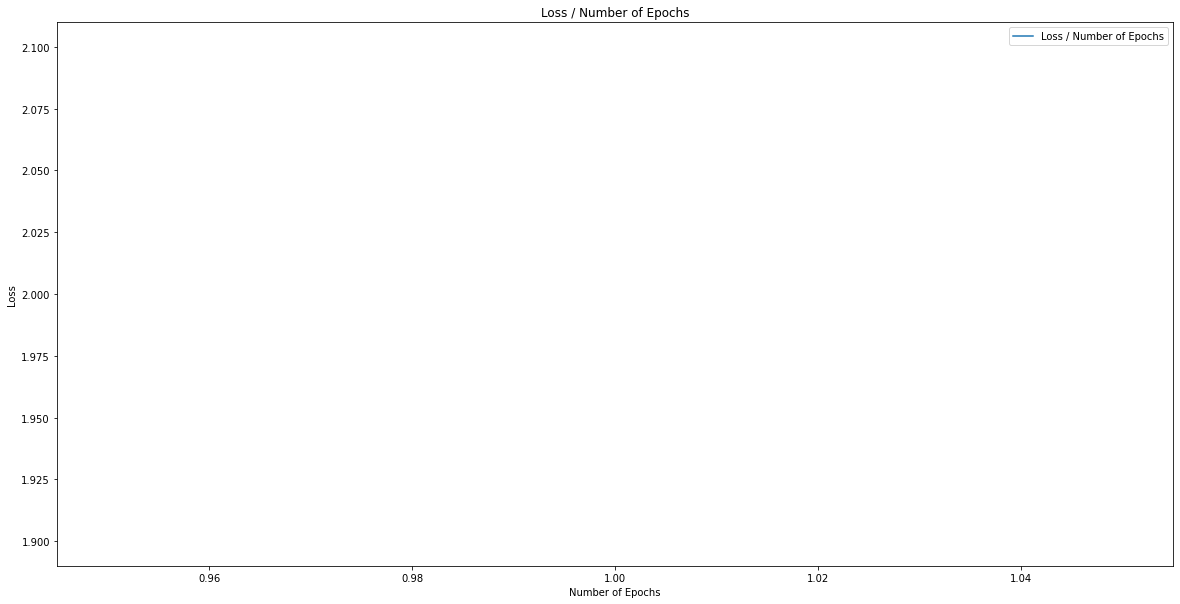

Train-Set: 
Accuracy: 0.29866774052820566%
Test-Set: 
Accuracy: 0.2953020134228188%


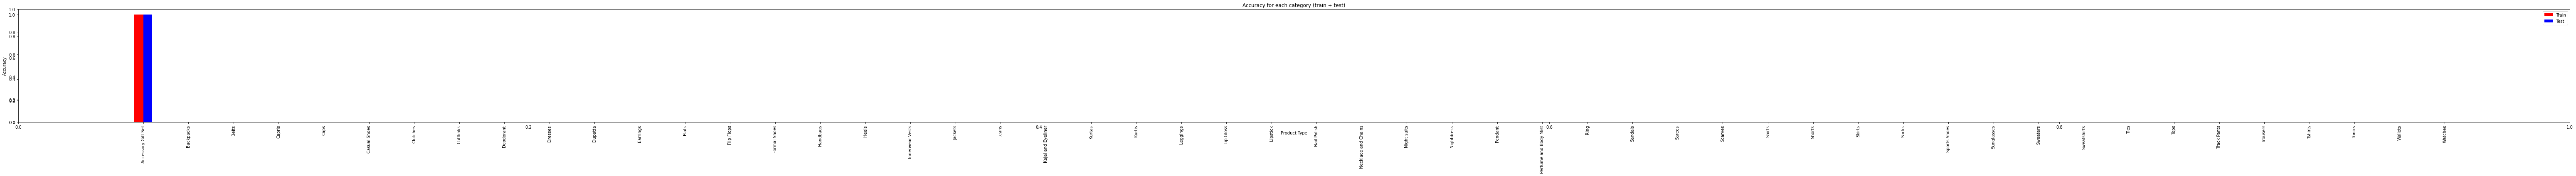

In [ ]:
# Assumptions:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

plot_loss_changes(fit(model, train_loader, device, criterion, optimizer))
plot_train_test_accuracies(class_accuracy(model,train_loader) , class_accuracy(model,test_loader) , classes)

print('Train-Set: ')
model_accuracy(model, train_loader)
print('Test-Set: ')
model_accuracy(model, test_loader)

As we can see, because of not normalizing the pixel values (0 to 255) , some dark pixels have lots of influences on category prediction, while most of these dark pixels have low effects and the darkness of pixels could not predict the class of product by itself. As a result of that, the accuracy is very low and the amount of average losses for each epoch leads to infinite numbers. <br>In fact, dark pixels have got the power to dictate the weights and biases , and as a result of that, the gradients will go out of our hands.<br> We should note most of the category accuracies are about 0 percent because of what explained, except for the class of "accessory gift set" which means our model predicts most of the classes as the "accessory gift set" cattegory.
<br> Because the accuracy for each class means recall of each class. (we don't have True negative)

## Part 4 - Normalized Training
Let's normalize the pixel values by deviding them to the maximum value of pixels (255) and make the values between 0 and 1.

### Transform Images to Gray Scale + Normalizing
It acts precisely like the "ToTensor" class, but is also Normalizes  the tensors by deviding them to the given maximum value, which is 255.

In [ ]:
class NormalizedToTensor(object):
    """Convert PIL Images in sample to pytorch Tensors Plus Normalizing It"""
    
    def __call__(self, image):
        image = np.array(image,dtype=np.float32) / 255
        # numpy image: H x W
        return torch.from_numpy(image)

Now we transform dataset into "NormalizedToTensor" and split the train and test sets like before.

In [77]:
transform = transforms.Compose( [transforms.Grayscale() , NormalizedToTensor()])
dataset = ImageFolder( root="./categorized_products" , transform=transform)

to_arange = dataset.targets
to_arange.sort()

# split the dataset into train and test sets randomly with split of 0.2 and assign their indices in the original set to train_indices and test_indices 
train_indicer, test_indicer = train_test_split(np.arange(len(to_arange)), test_size= 0.2, shuffle=True, stratify=to_arange)

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indicer)
test_sampler = SubsetRandomSampler(test_indicer)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=16)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=16)

Lets train our model and see the results.

epoch 1, train_loss: 3.858, time elapsed: 13.272146 seconds
epoch 2, train_loss: 3.469, time elapsed: 13.227834 seconds
epoch 3, train_loss: 3.437, time elapsed: 13.019026 seconds
epoch 4, train_loss: 3.341, time elapsed: 13.029603 seconds
epoch 5, train_loss: 3.001, time elapsed: 13.217628 seconds
epoch 6, train_loss: 2.794, time elapsed: 13.174613 seconds
epoch 7, train_loss: 2.682, time elapsed: 13.020335 seconds
epoch 8, train_loss: 2.562, time elapsed: 12.996108 seconds
epoch 9, train_loss: 2.441, time elapsed: 13.111625 seconds
epoch 10, train_loss: 2.284, time elapsed: 12.950829 seconds
total training time: 2.184 minutes


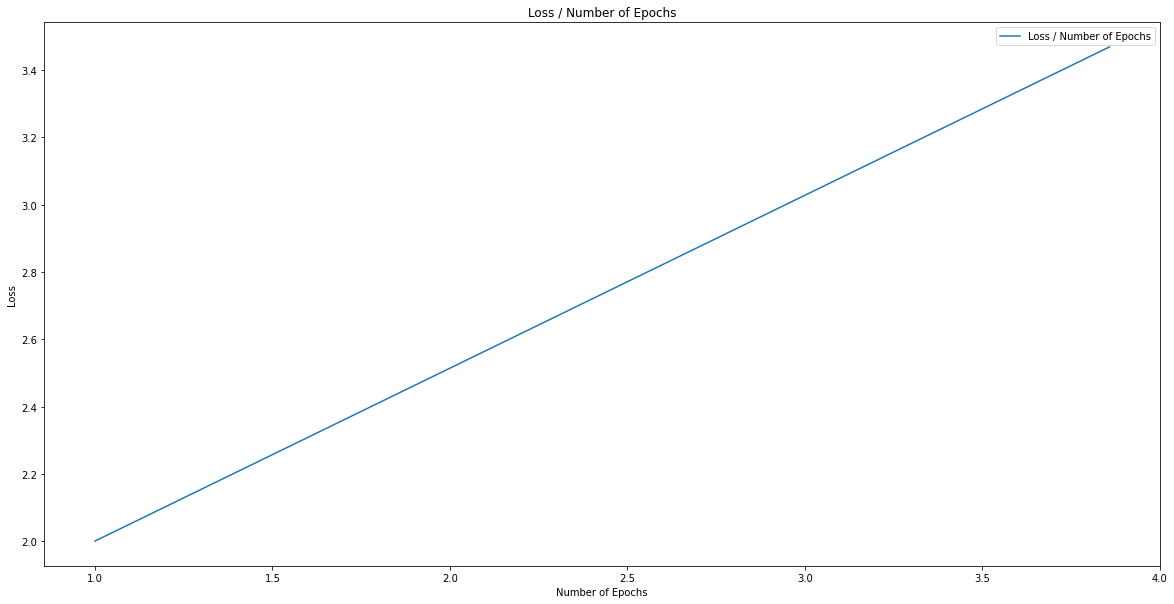

Train-Set: 
Accuracy: 35.49447968052619%
Test-Set: 
Accuracy: 35.47651006711409%


35.47651006711409

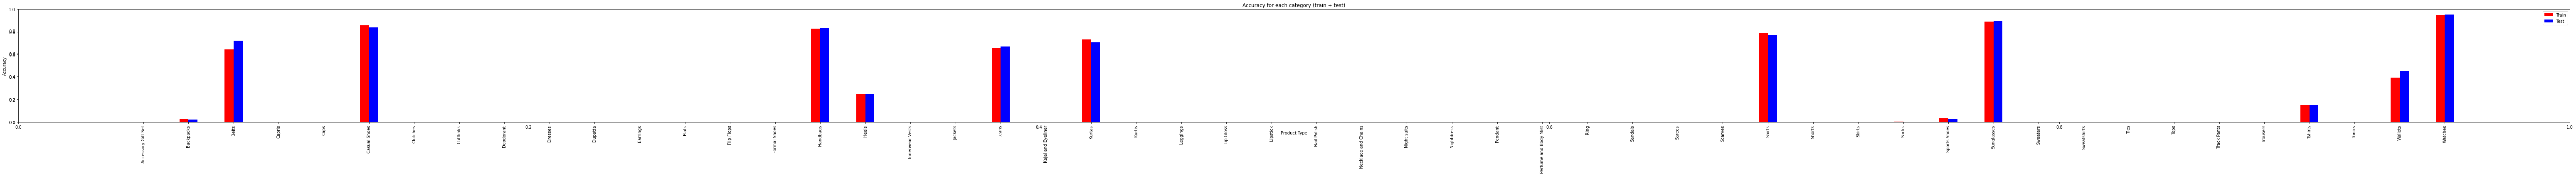

In [70]:
model = Model(len(classes))
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

plot_loss_changes(fit(model, train_loader, device, criterion, optimizer))
plot_train_test_accuracies(class_accuracy(model,train_loader) , class_accuracy(model,test_loader) , classes)

print('Train-Set: ')
model_accuracy(model, train_loader)
print('Test-Set: ')
model_accuracy(model, test_loader)

As we can see because of solving the problems described in part 3, the total accuracy has been improved significantly. Average losses decreased and losses per epochs are increasing linearly, which means the convergence of our net is pretty good. Also the recalls for each class indicates that our model is predicting more variously and is not biased by the category which got darkest pixels.

## Part 5 - Zero Weights at Start
### A - let's make zero's:

In [71]:
model = Model(len(classes))
model = model.to(device)
model.start_weights(0)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Check:

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

layer1.weight tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
layer1.bias tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
layer2.weight tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
layer2.bias tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
layer3.weight tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
layer3.bi

Model fit and analysis:

epoch 1, train_loss: 3.923, time elapsed: 13.086883 seconds
epoch 2, train_loss: 3.869, time elapsed: 13.073442 seconds
epoch 3, train_loss: 3.820, time elapsed: 12.951582 seconds
epoch 4, train_loss: 3.776, time elapsed: 12.888604 seconds
epoch 5, train_loss: 3.737, time elapsed: 12.916365 seconds
epoch 6, train_loss: 3.703, time elapsed: 12.813421 seconds
epoch 7, train_loss: 3.674, time elapsed: 12.875437 seconds
epoch 8, train_loss: 3.648, time elapsed: 12.882831 seconds
epoch 9, train_loss: 3.625, time elapsed: 13.072379 seconds
epoch 10, train_loss: 3.606, time elapsed: 12.97482 seconds
total training time: 2.159 minutes


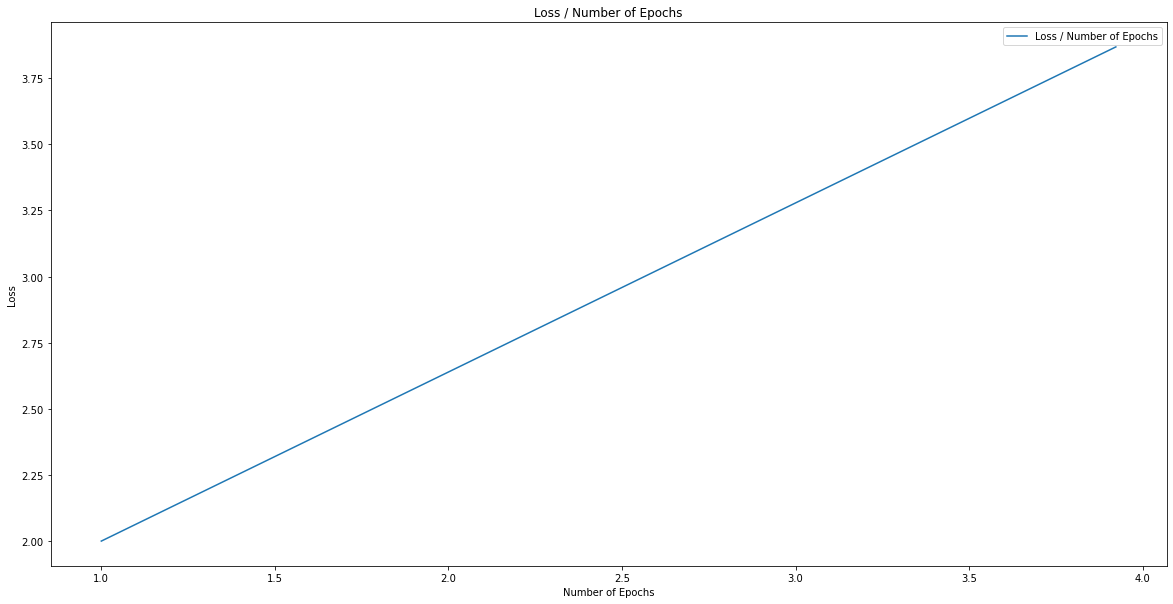

Train-Set: 
Accuracy: 9.48689553340716%
Test-Set: 
Accuracy: 9.48993288590604%


9.48993288590604

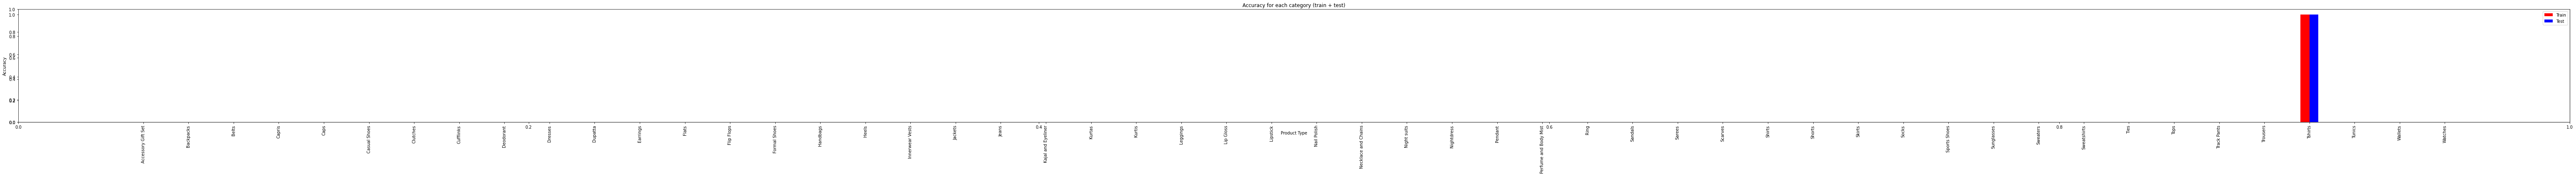

In [72]:
plot_loss_changes(fit(model, train_loader, device, criterion, optimizer))
plot_train_test_accuracies(class_accuracy(model,train_loader) , class_accuracy(model,test_loader) , classes)

print('Train-Set: ')
model_accuracy(model, train_loader)
print('Test-Set: ')
model_accuracy(model, test_loader)

The total accuracies have been decreased to a liniear-model-like accuracy. The reason why it happens is because our loss function changes all the weights in each layer equally and during each iteration so that weights in one layer will be the same. As a result of that, hidden units will be symmetric for all our iterations. <br>The losses are still increasing linearly which is good, but the whole model has not the complexity which it needs to predict our various product categories. Also the losses are decreasing very slowly during each epoch, because 0 values prevent the weights and biases to change significantly.<br>Also the model still predicts just one category most of the time and this is because the weights have been optimized to reduce the losses on one category and predicts it as well as it can. random weights at start helps the model to break the symetry (producing and doing same calculations) and improve the accuracies.
<br> 
###B - Starting Weights Optimization:
Today there are various types of weights initializations and there is lots of articles and researches on this topic. Other than zero and random initializations: <br>He initialization: we just simply multiply random initialization with this formula: (https://drive.google.com/file/d/1ObnV1Qzsb5NtETU85TFO79d533Nqsk_z/view?usp=sharing) To see how effective this solution is.<br> Xavier initialization: It is same as He initialization but it is used for tanh() activation function, in this method 2 is replaced with 1. The formula: (https://drive.google.com/file/d/1G764qqMOTSJ-5lhUsZ027D5LeRcaEK0x/view?usp=sharing)

## Part 6 - Finding Optimized Learning Rate

### A - Finding Best LR:

In [ ]:
candidates = [0.1, 0.01, 0.001, 0.5, 0.05, 0.005, 0.9, 0.09, 0.009]
results = []
for i in candidates:
  print("Learning Rate = ",i)
  model = Model(len(classes))
  model = model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=i)
  fit(model, train_loader, device, criterion, optimizer)
  print('Train-Set: ')
  tr = model_accuracy(model, train_loader)
  print('Test-Set: ')
  ts = model_accuracy(model, test_loader)
  results.append(tuple([i,tr,ts]))
  print("\n")

Learning Rate =  0.1
epoch 1, train_loss: 3.217, time elapsed: 14.603244 seconds
epoch 2, train_loss: 2.498, time elapsed: 14.547307 seconds
epoch 3, train_loss: 2.073, time elapsed: 14.449465 seconds
epoch 4, train_loss: 1.832, time elapsed: 14.433008 seconds
epoch 5, train_loss: 1.655, time elapsed: 14.486018 seconds
epoch 6, train_loss: 1.518, time elapsed: 14.522961 seconds
epoch 7, train_loss: 1.420, time elapsed: 14.463327 seconds
epoch 8, train_loss: 1.336, time elapsed: 14.472327 seconds
epoch 9, train_loss: 1.282, time elapsed: 14.52256 seconds
epoch 10, train_loss: 1.230, time elapsed: 14.44011 seconds
total training time: 2.416 minutes
Train-Set: 
Accuracy: 58.48853988388872%
Test-Set: 
Accuracy: 57.395973154362416%


Learning Rate =  0.01
epoch 1, train_loss: 3.674, time elapsed: 14.401923 seconds
epoch 2, train_loss: 3.340, time elapsed: 14.454619 seconds
epoch 3, train_loss: 2.839, time elapsed: 14.340848 seconds
epoch 4, train_loss: 2.597, time elapsed: 14.418353 seconds

### B - Illustrations of best LR and Discussion

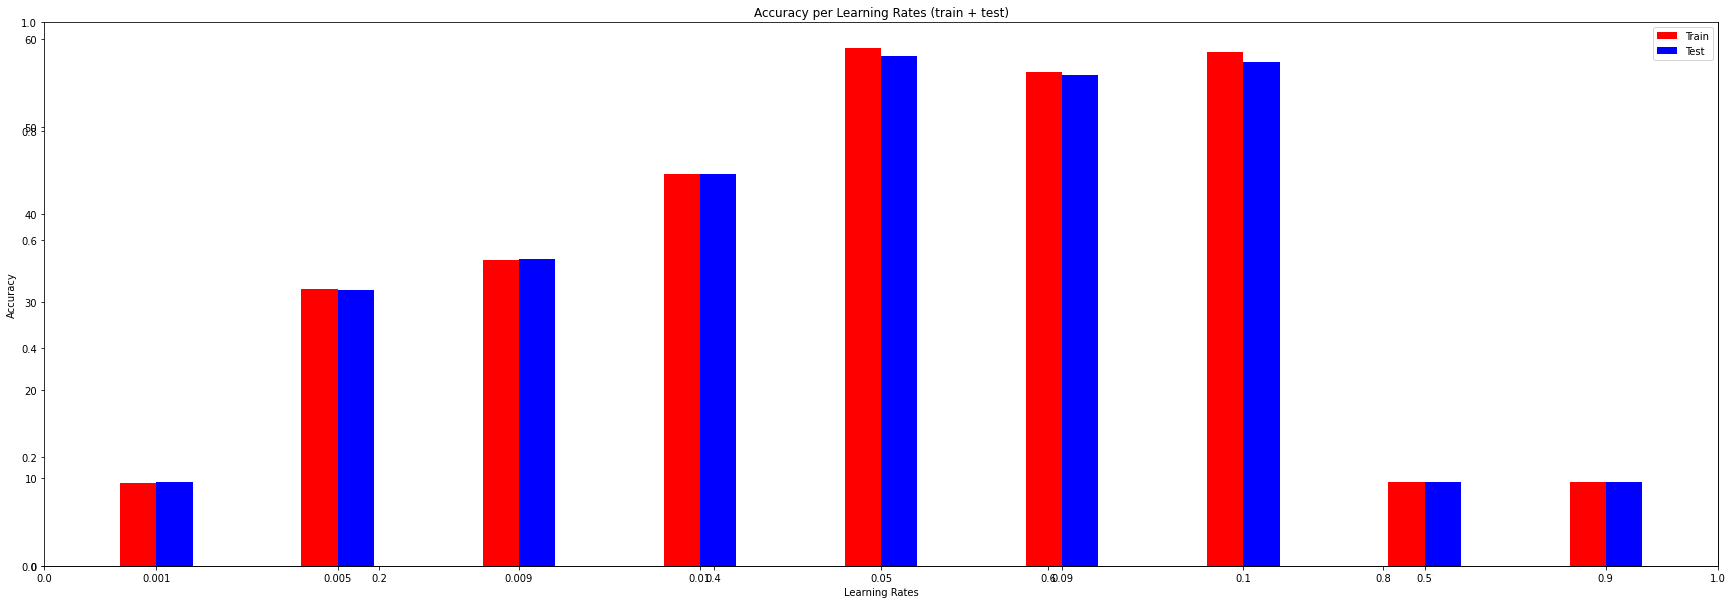

In [ ]:
results = sorted(results, key=lambda x: x[0])
lrs = []
tr_accs = []
te_accs = []
for i in results:
  lrs.append(i[0])
  tr_accs.append(i[1])
  te_accs.append(i[2])

fig = plt.figure(figsize=(30,10),frameon=False)
plt.xlabel('Learning Rates')
plt.ylabel('Accuracy')
ax = fig.subplots()
ax.bar(np.arange(len(lrs)) - 0.1, tr_accs , 0.2 , label='Train' , color='red')
ax.bar(np.arange(len(lrs)) + 0.1, te_accs , 0.2 , label='Test' , color='blue')
ax.set_xticks(np.arange(len(lrs)))
ax.set_xticklabels(lrs)
ax.set_title("Accuracy per Learning Rates (train + test)")
ax.legend()

From the plot and the code above, we could conclude that the best step size for the stochastic gradient decent (which we know it as learning rate) is equal to 0.05 which has the total accuracy of around 58% , and we will use this LR for further parts.<br> The learning rate is the value which indicates the speed of adaptation of the model during fitting; meaning larger LRs need less epochs to learn and smaller rates need more epochs because of the slowness of updating weights.<br> A model with high learning rate values will lead us to the point which it converges too quickly to a suboptimal solution. Clockwise, low LRs, will stuck the model in local maxima and make it to not converge in the number of epochs desired.<br>In conclusion, we can see that very low LR make our model vulnerable to low amount of epochs and reduces accuracy, while high LR has converged the model too quickly to a suboptimal solution.

## Part 7 - Batch Size Analysis
### A - Batch_Size = 32 & 128

Batch Size =  32
epoch 1, train_loss: 2.962, time elapsed: 18.626554 seconds
epoch 2, train_loss: 2.053, time elapsed: 18.43359 seconds
epoch 3, train_loss: 1.708, time elapsed: 18.480957 seconds
epoch 4, train_loss: 1.522, time elapsed: 18.347179 seconds
epoch 5, train_loss: 1.394, time elapsed: 18.319897 seconds
epoch 6, train_loss: 1.308, time elapsed: 18.198673 seconds
epoch 7, train_loss: 1.226, time elapsed: 18.141646 seconds
epoch 8, train_loss: 1.172, time elapsed: 18.286147 seconds
epoch 9, train_loss: 1.122, time elapsed: 18.242739 seconds
epoch 10, train_loss: 1.062, time elapsed: 18.126295 seconds
total training time: 3.053 minutes


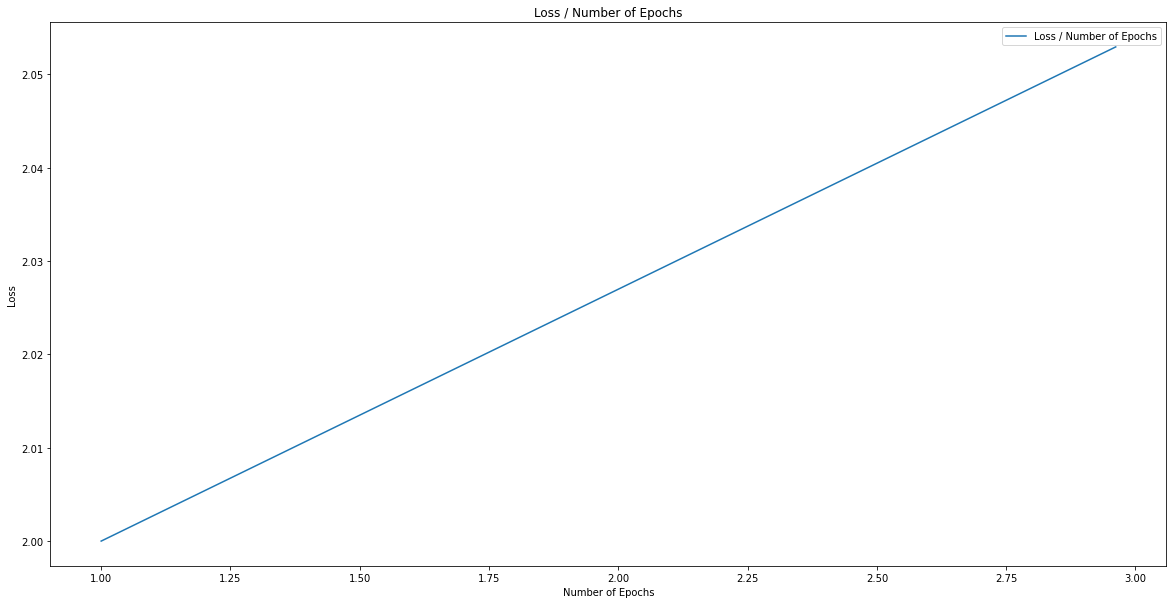

Train-Set: 
Accuracy: 27.000906070673512%
Test-Set: 
Accuracy: 26.42953020134228%


Batch Size =  128
epoch 1, train_loss: 3.476, time elapsed: 12.926869 seconds
epoch 2, train_loss: 2.881, time elapsed: 13.054728 seconds
epoch 3, train_loss: 2.531, time elapsed: 12.961179 seconds
epoch 4, train_loss: 2.211, time elapsed: 12.919923 seconds
epoch 5, train_loss: 1.988, time elapsed: 12.877596 seconds
epoch 6, train_loss: 1.858, time elapsed: 12.8141 seconds
epoch 7, train_loss: 1.723, time elapsed: 12.906235 seconds
epoch 8, train_loss: 1.640, time elapsed: 12.706144 seconds


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f10bcb6d208>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f10bcb6d208>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f10bcb6d208>>
Exception ignored in

epoch 9, train_loss: 1.566, time elapsed: 13.825448 seconds


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f10bcb6d208>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f10bcb6d208>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f10bcb6d208>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f10bcb6d208>>
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f10bcb6d208>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/di

epoch 10, train_loss: 1.516, time elapsed: 15.891109 seconds
total training time: 2.215 minutes


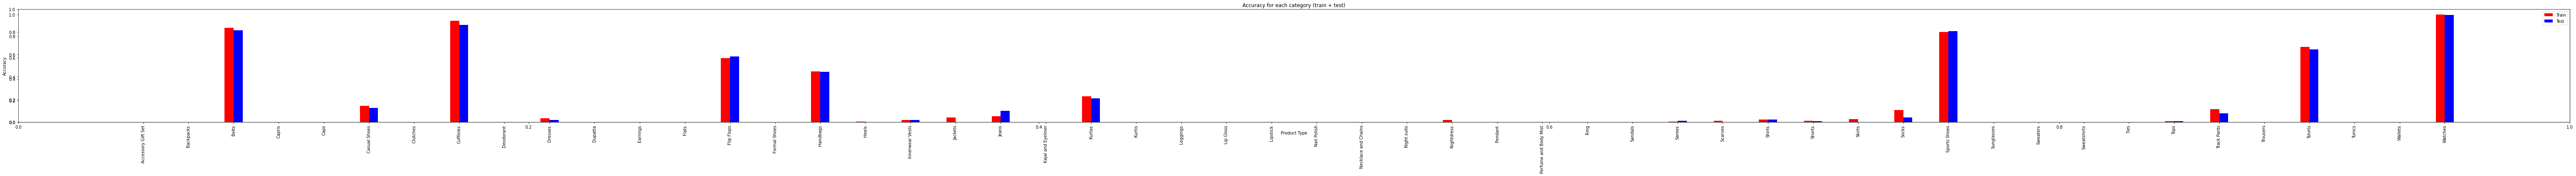

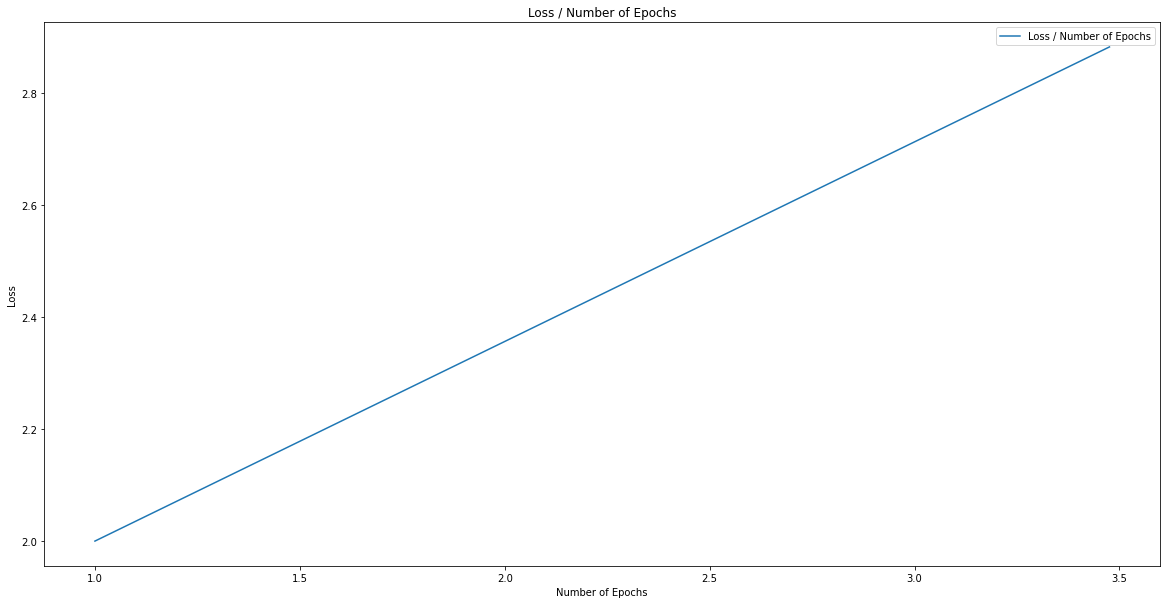

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f10bcb6d208>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f10ba244128>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f10bcb6d208>>
Traceback (most rece

Train-Set: 
Accuracy: 42.377260981912144%
Test-Set: 
Accuracy: 42.41610738255034%




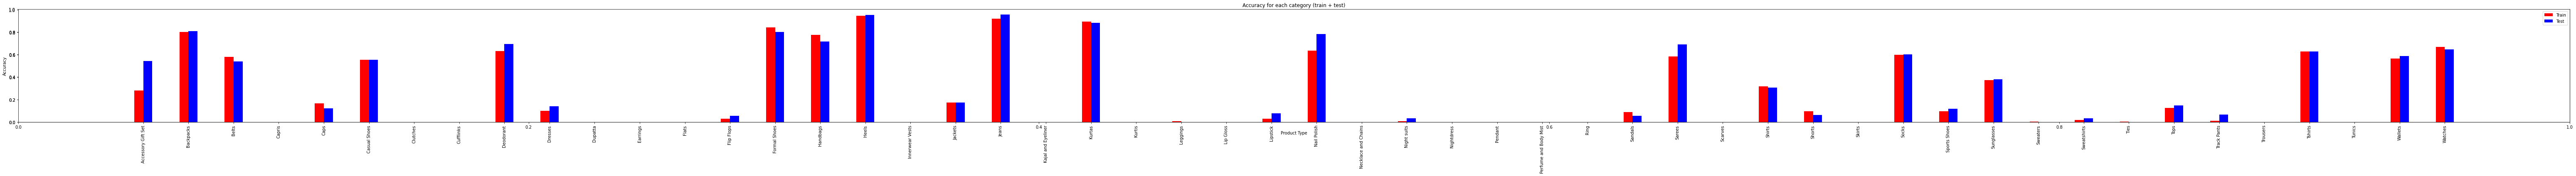

In [78]:
candidates = [32,128]

for i in candidates:
  print("Batch Size = ",i)
  train_loader = torch.utils.data.DataLoader(dataset, batch_size=i, sampler=train_sampler, num_workers=16)
  test_loader = torch.utils.data.DataLoader(dataset, batch_size=i, sampler=test_sampler, num_workers=16)

  model = Model(len(classes))
  model = model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

  plot_loss_changes(fit(model, train_loader, device, criterion, optimizer))
  plot_train_test_accuracies(class_accuracy(model,train_loader) , class_accuracy(model,test_loader) , classes)

  print('Train-Set: ')
  model_accuracy(model, train_loader)
  print('Test-Set: ')
  model_accuracy(model, test_loader)
  print("\n")

### B - Small & Big Batch_Size Pros-Cons and Analysis
Very Big batch sizes could lead to overfitting and less generalizations. Normally big batches on the other hand, allows us to speedup computations from the parallelism of GPUs.<br> Using Small Batches has a high probability of leading to faster convergence to non-optimal and underfit solutions. A fact is that in small batches, the model starts to learn data even before seeing it. Actually this means the high amount of generalization.

As we can see above, both 32 and 128 batch sizes decrease the model accuracy on both train and test sets with our optimal LR. However, to compensate large batch size effect on the model, we should "increase" the LR:

epoch 1, train_loss: 3.416, time elapsed: 13.010452 seconds
epoch 2, train_loss: 2.845, time elapsed: 12.814923 seconds
epoch 3, train_loss: 2.445, time elapsed: 12.924367 seconds
epoch 4, train_loss: 2.190, time elapsed: 12.799091 seconds
epoch 5, train_loss: 2.002, time elapsed: 12.791773 seconds
epoch 6, train_loss: 1.826, time elapsed: 12.718968 seconds
epoch 7, train_loss: 1.718, time elapsed: 12.818174 seconds
epoch 8, train_loss: 1.626, time elapsed: 12.732782 seconds
epoch 9, train_loss: 1.539, time elapsed: 12.765359 seconds
epoch 10, train_loss: 1.479, time elapsed: 12.563087 seconds
total training time: 2.132 minutes


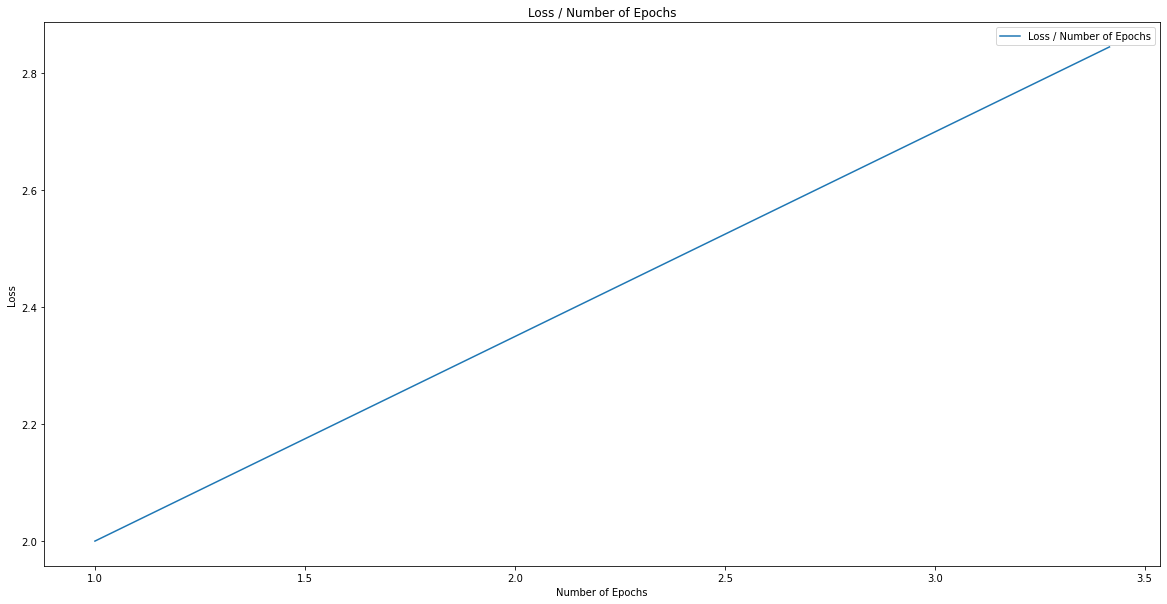

Train-Set: 
Accuracy: 52.31383603476627%
Test-Set: 
Accuracy: 51.852348993288594%




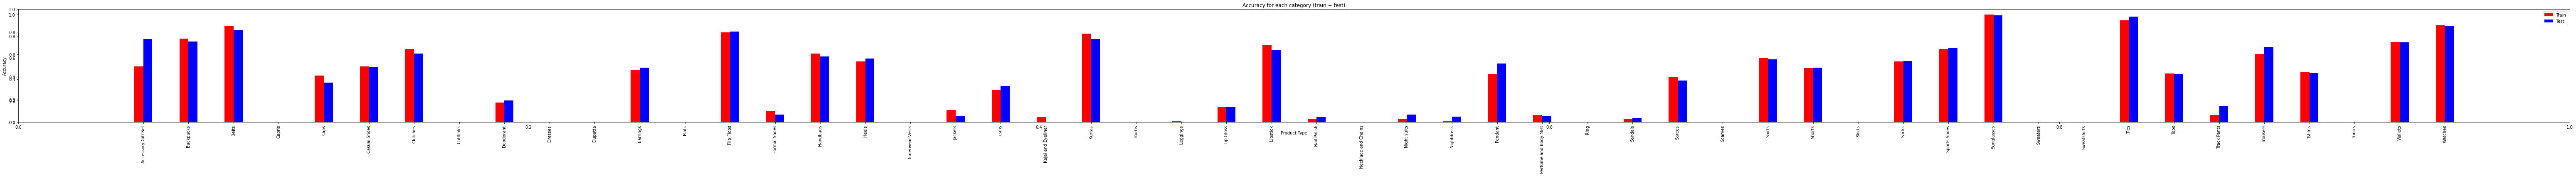

In [79]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, sampler=train_sampler, num_workers=16)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=128, sampler=test_sampler, num_workers=16)

model = Model(len(classes))
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.07)

plot_loss_changes(fit(model, train_loader, device, criterion, optimizer))
plot_train_test_accuracies(class_accuracy(model,train_loader) , class_accuracy(model,test_loader) , classes)

print('Train-Set: ')
model_accuracy(model, train_loader)
print('Test-Set: ')
model_accuracy(model, test_loader)
print("\n")

epoch 1, train_loss: 3.565, time elapsed: 12.958346 seconds
epoch 2, train_loss: 3.079, time elapsed: 12.847949 seconds
epoch 3, train_loss: 2.693, time elapsed: 12.737934 seconds
epoch 4, train_loss: 2.404, time elapsed: 12.597701 seconds
epoch 5, train_loss: 2.198, time elapsed: 12.613008 seconds
epoch 6, train_loss: 2.003, time elapsed: 12.727587 seconds
epoch 7, train_loss: 1.868, time elapsed: 12.651602 seconds
epoch 8, train_loss: 1.778, time elapsed: 12.566571 seconds
epoch 9, train_loss: 1.680, time elapsed: 12.748149 seconds
epoch 10, train_loss: 1.627, time elapsed: 12.962472 seconds
total training time: 2.124 minutes


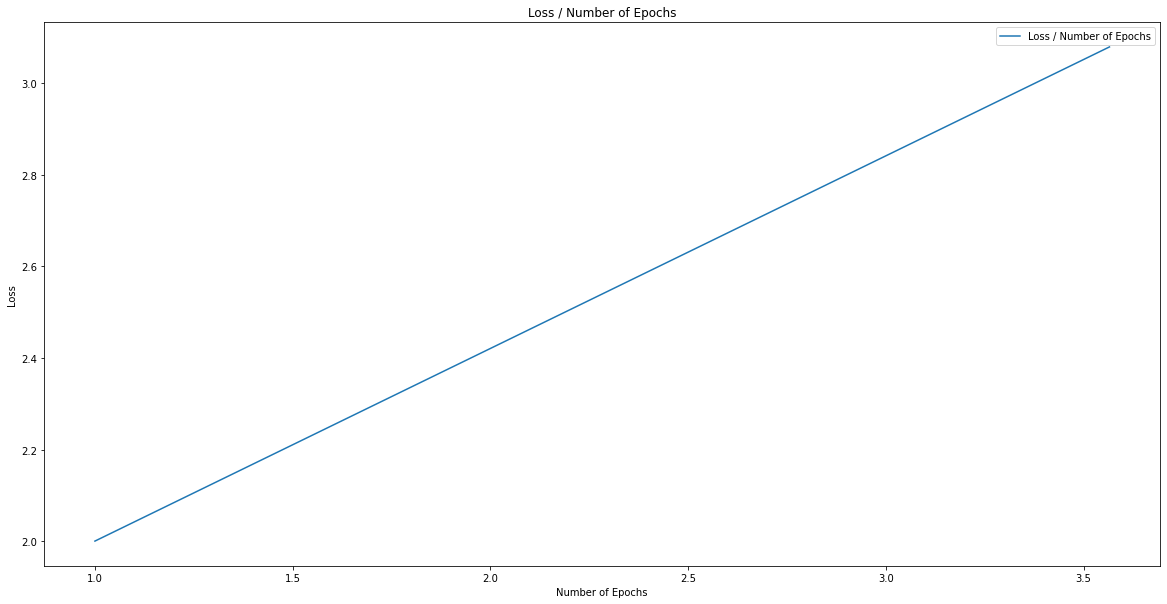

Train-Set: 
Accuracy: 49.142588677472396%
Test-Set: 
Accuracy: 48.80536912751678%




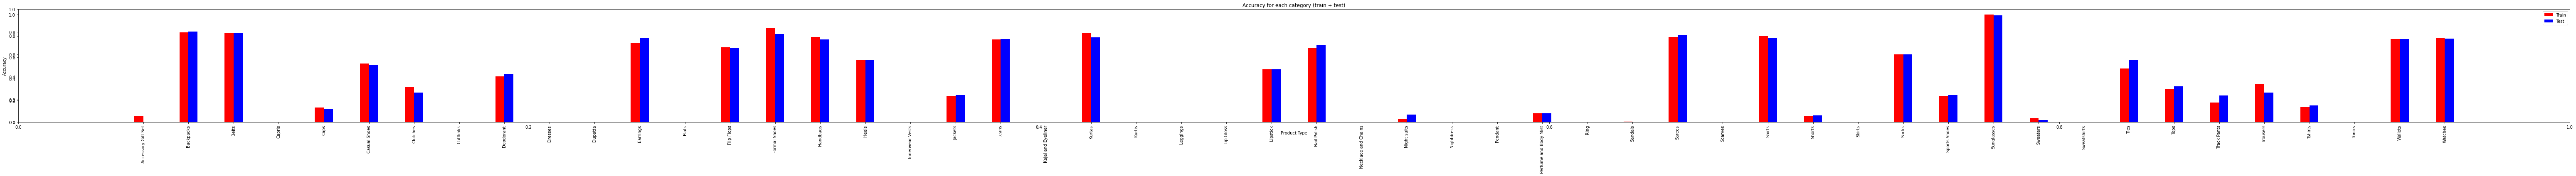

In [80]:
model = Model(len(classes))
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.03)


plot_loss_changes(fit(model, train_loader, device, criterion, optimizer))
plot_train_test_accuracies(class_accuracy(model,train_loader) , class_accuracy(model,test_loader) , classes)

print('Train-Set: ')
model_accuracy(model, train_loader)
print('Test-Set: ')
model_accuracy(model, test_loader)
print("\n")

As we can see, increasing the LR (0.02) for our large batch will lead us to the point which we can compensate some of the lost accuracies, while decreasing it would decrease it.

## Part 8 - Momentum
### A - Momentum Functionality: 
Momentum has a value between 0 and 1. It increases the size of steps we take to move to the optimal point by jumping from a local optima or generally take larger steps in our state space. However, Low values of momentum would not efficiently help us to jump out of the local optimal point.<br> We use Momentum to in the pursuit of not get stuck in a local optimum. It also helps us to speed up convergence. Plus, in case of changing directions during gradients, momentum helps us to smooth out the variations.
<br> Aslo we should note that most of the time, momentum increases the model complexity and computing times.

### B - Momentum = 0.5, 0.9, 0.98:

In [81]:
candidates = [0.5 , 0.9 , 0.98]
for i in candidates:
  print("Momentum = ",i)
  model = Model(len(classes))
  model = model.to(device)
  # model.start_weights(0)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum = i)

  plot_loss_changes(fit(model, train_loader, device, criterion, optimizer))
  plot_train_test_accuracies(class_accuracy(model,train_loader) , class_accuracy(model,test_loader) , classes)

  print('Train-Set: ')
  model_accuracy(model, train_loader)
  print('Test-Set: ')
  model_accuracy(model, test_loader)
  print("\n")

Momentum =  0.5
epoch 1, train_loss: 3.303, time elapsed: 13.233584 seconds
epoch 2, train_loss: 2.509, time elapsed: 13.033062 seconds
epoch 3, train_loss: 2.129, time elapsed: 13.110356 seconds
epoch 4, train_loss: 1.842, time elapsed: 12.991497 seconds


KeyboardInterrupt: ignored

As the results indicate, while we use our optimal LR, larger momentums make us to take large steps and miss the global result. As a result of that, the accuracy goes down. So we use the lower number for the momentum wich is 0.5 

### C - Large Momentums:
Large momentums will not always cause good accuracies. In fact, with large learning rates, we should use lower momentums. if we want to increase momentum, Lower LRs will be used for better performance. Because momentum and LR are both lead us to the point that convergence will happen faster by increasing our steps during SGD. If we use momentum and LR at high values, there is a high chance that we skip the global omtima with our huge step.

## Part 9 - Epochs
### A - Epochs = 20

epoch 1, train_loss: 3.312, time elapsed: 13.917318 seconds
epoch 2, train_loss: 2.564, time elapsed: 12.866022 seconds
epoch 3, train_loss: 2.132, time elapsed: 13.063082 seconds
epoch 4, train_loss: 1.840, time elapsed: 12.917897 seconds
epoch 5, train_loss: 1.668, time elapsed: 12.985383 seconds
epoch 6, train_loss: 1.545, time elapsed: 13.036997 seconds
epoch 7, train_loss: 1.431, time elapsed: 12.989599 seconds
epoch 8, train_loss: 1.378, time elapsed: 13.095366 seconds
epoch 9, train_loss: 1.304, time elapsed: 13.091446 seconds
epoch 10, train_loss: 1.248, time elapsed: 12.977709 seconds
epoch 11, train_loss: 1.218, time elapsed: 12.916455 seconds
epoch 12, train_loss: 1.158, time elapsed: 12.867889 seconds
epoch 13, train_loss: 1.118, time elapsed: 12.754319 seconds
epoch 14, train_loss: 1.094, time elapsed: 12.749004 seconds
epoch 15, train_loss: 1.057, time elapsed: 12.694379 seconds
epoch 16, train_loss: 1.028, time elapsed: 12.779695 seconds
epoch 17, train_loss: 1.011, time

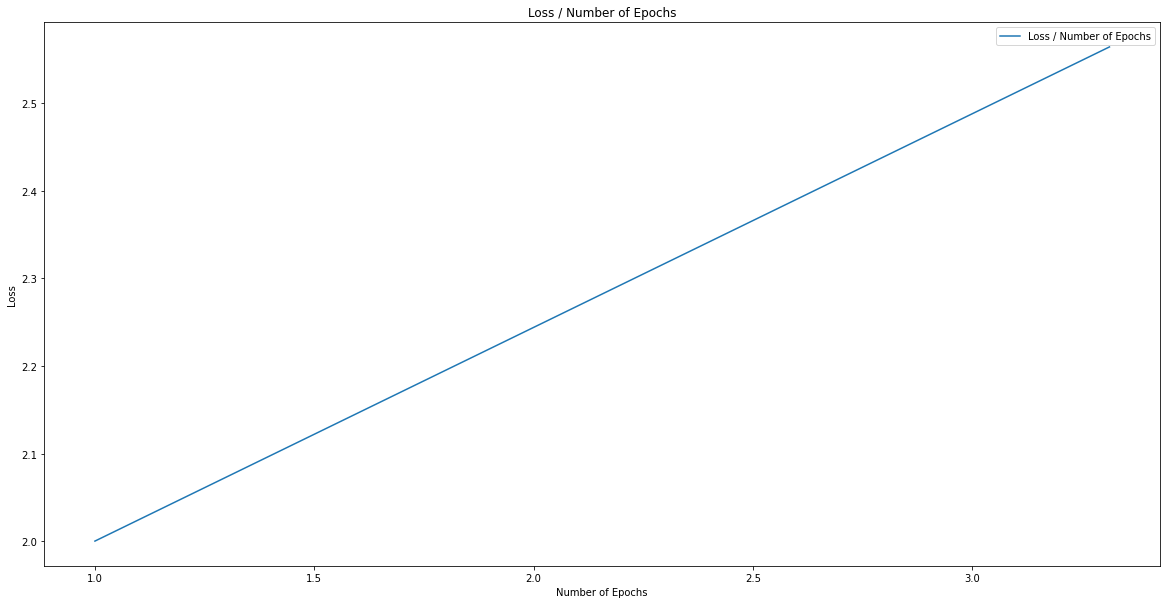

Train-Set: 
Accuracy: 67.40830229202322%
Test-Set: 
Accuracy: 66.28187919463087%




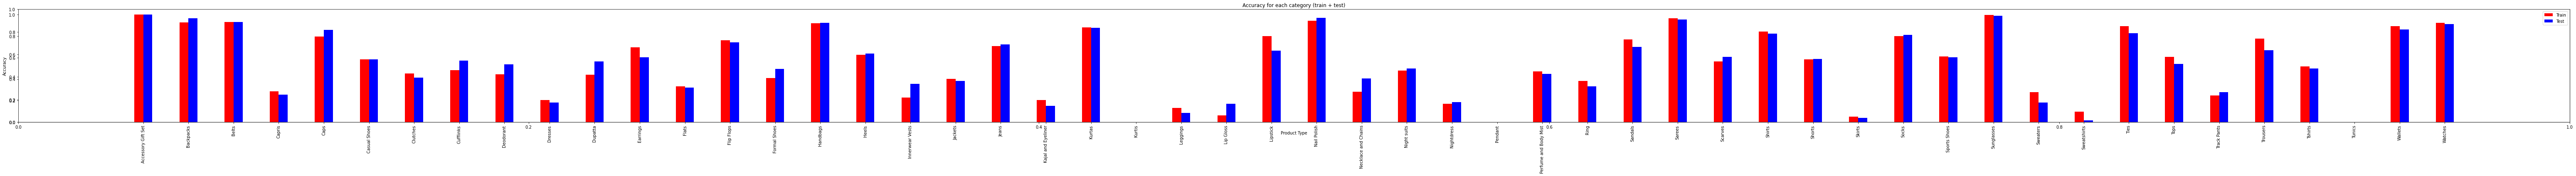

In [ ]:
model = Model(len(classes))
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum = 0.5)

plot_loss_changes(fit(model, train_loader, device, criterion, optimizer, num_epochs=20))
plot_train_test_accuracies(class_accuracy(model,train_loader) , class_accuracy(model,test_loader) , classes)

print('Train-Set: ')
model_accuracy(model, train_loader)
print('Test-Set: ')
model_accuracy(model, test_loader)
print("\n")

We can clearly see that our model performs much better with 20 epochs rather than 10. We should consider that number of epochs should not be very high or very low (as described further). Here though, 20 epochs done well on total accuracy, each class accuracy (recall), and lowering losses during each epoch.

### B - Why Multiple Epochs?
Gradient decent is an iterative algorithm; which means it uses small steps to improve weights from each epoch. In fact, during each epoch, we feed all training data to the model and update the weights by small steps during SGD. The Gradient decent doesn't have a clue that what is happening during last epochs, it just updates weights to reduce the amount of loss. So that is why we need multiple epochs.

### C - Epochs <-?-> Accuracy
Large number of epochs could overfit the model by adding to the model complexity and decreases model generalization. It will acts perfectly on train set (memorize it) and pretty badly on test set. <br>We should use the technique called "early stop" and stop learning when the model performs best predictions on test set.

## Part 10 - Activation functions

Activation Function =  <built-in method tanh of type object at 0x7f111b0a3340>
epoch 1, train_loss: 2.767, time elapsed: 13.834935 seconds
epoch 2, train_loss: 1.889, time elapsed: 13.777926 seconds
epoch 3, train_loss: 1.618, time elapsed: 13.764947 seconds
epoch 4, train_loss: 1.414, time elapsed: 13.896518 seconds
epoch 5, train_loss: 1.301, time elapsed: 13.815816 seconds
epoch 6, train_loss: 1.229, time elapsed: 13.787258 seconds
epoch 7, train_loss: 1.157, time elapsed: 13.970159 seconds
epoch 8, train_loss: 1.113, time elapsed: 13.692244 seconds
epoch 9, train_loss: 1.076, time elapsed: 14.073822 seconds


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f10b9e85550>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f10b9e85550>>
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f10b9e85550>>
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Traceback (most recent call las

epoch 10, train_loss: 1.032, time elapsed: 14.799084 seconds
total training time: 2.324 minutes


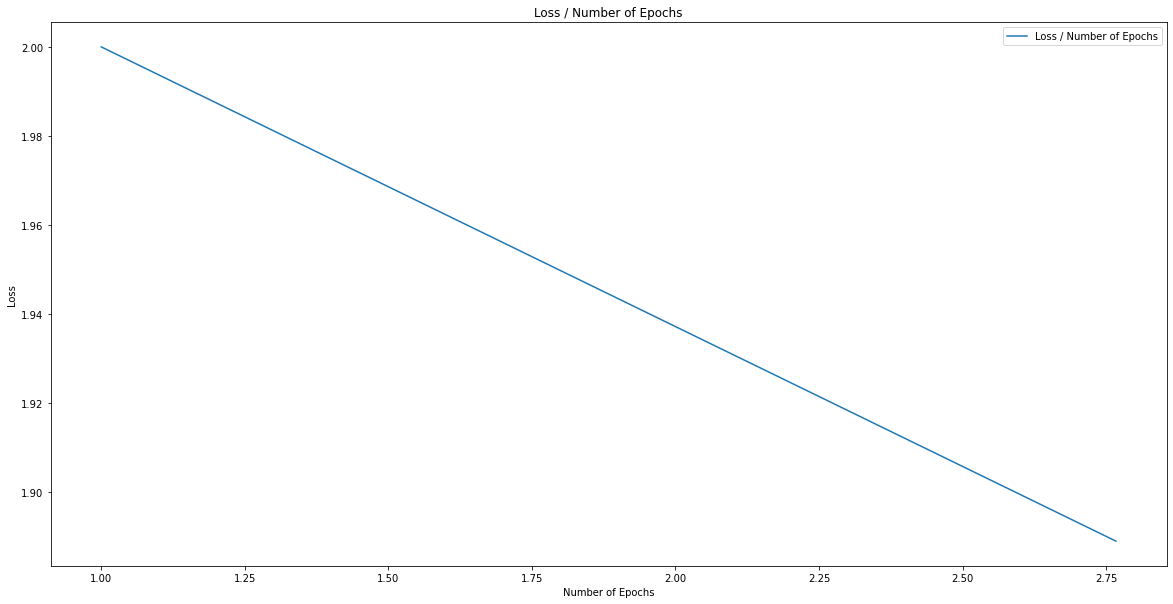

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f10b9e85550>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f10b9e85550>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f10b9e85550>>
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f10b9e85550>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  Fi

Train-Set: 
Accuracy: 61.92154099130843%
Test-Set: 
Accuracy: 61.46308724832215%


Activation Function =  <function leaky_relu at 0x7f10d2de67b8>
epoch 1, train_loss: 3.407, time elapsed: 13.333807 seconds
epoch 2, train_loss: 2.677, time elapsed: 13.890139 seconds
epoch 3, train_loss: 2.308, time elapsed: 13.919203 seconds
epoch 4, train_loss: 1.997, time elapsed: 14.025132 seconds
epoch 5, train_loss: 1.798, time elapsed: 14.069669 seconds
epoch 6, train_loss: 1.678, time elapsed: 14.071135 seconds
epoch 7, train_loss: 1.542, time elapsed: 13.89148 seconds
epoch 8, train_loss: 1.443, time elapsed: 13.957245 seconds
epoch 9, train_loss: 1.371, time elapsed: 13.807725 seconds
epoch 10, train_loss: 1.313, time elapsed: 13.835188 seconds
total training time: 2.313 minutes


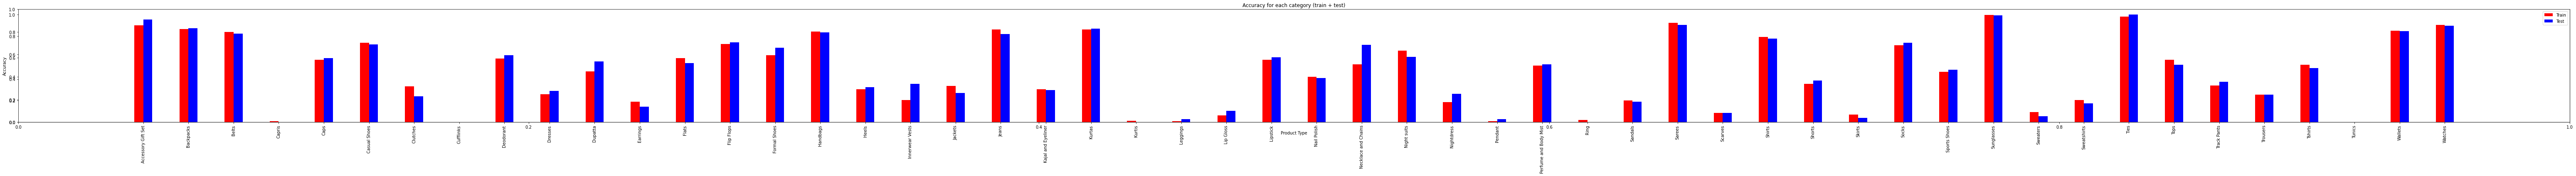

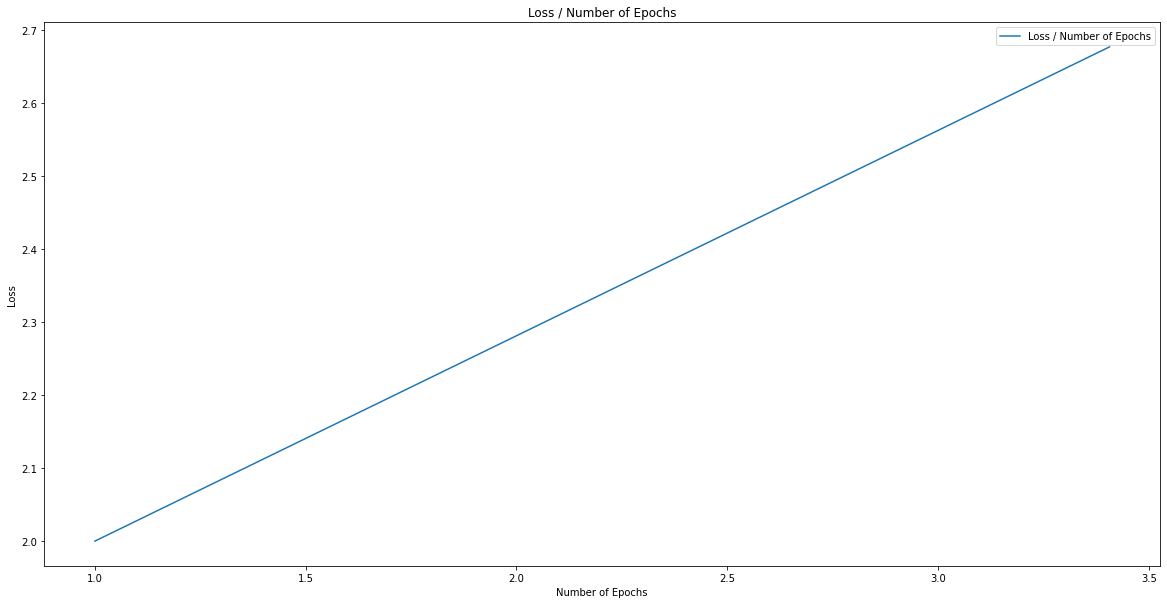

Train-Set: 
Accuracy: 55.146145843820264%
Test-Set: 
Accuracy: 54.671140939597315%




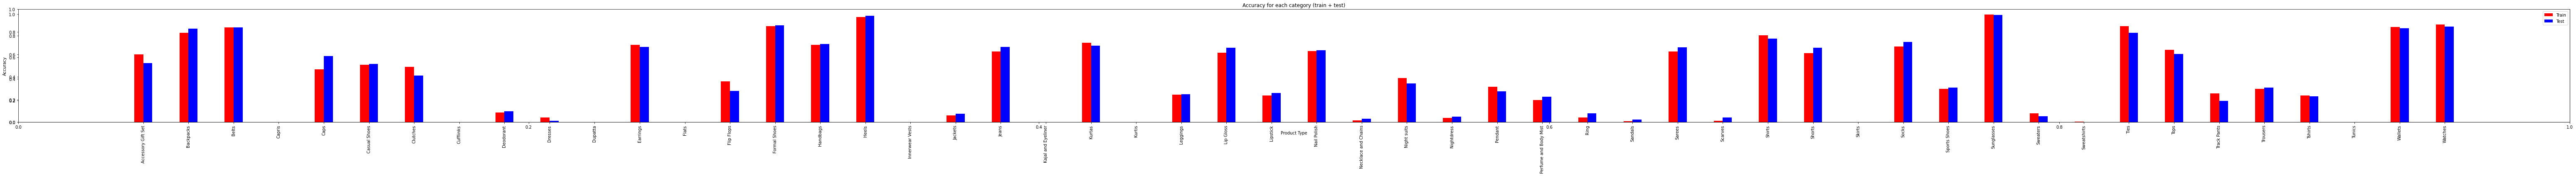

In [ ]:
candidates = [torch.tanh,F.leaky_relu]
for i in candidates:
  print("Activation Function = ",i)

  model = Model(len(classes), i)
  model = model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum = 0.5)

  plot_loss_changes(fit(model, train_loader, device, criterion, optimizer))
  plot_train_test_accuracies(class_accuracy(model,train_loader) , class_accuracy(model,test_loader) , classes)

  print('Train-Set: ')
  model_accuracy(model, train_loader)
  print('Test-Set: ')
  model_accuracy(model, test_loader)
  print("\n")

Leaky relu is here to solve the problem of relu. The leak helps to increase the range of the ReLU function. Usually, the value of a is 0.01 or so. The range of the Leaky ReLU is (-infinity to infinity). it is more balanced and rapid-in-learning algorithm. It also is so vulnerable to negative weights when we apply it to the random initialized weights. Here, the leaky relu has less accuracy than relu because it may returns the local result rather than the global one (because it is fast and has a chance to stuck in locals). It is a monotonic function in nature, like ReLu.<br><br>
On the other hand, tanh is a hyperbolic tangent Activation Function and it is like logistic sigmoid but better. The range of the tanh function is from (-1 to 1) and because of that, the steps are very small and when the dataset is large or the model is huge, we need more epochs and it has the disadvantage of calculating much more equations in more time. Steps are small and that is why the losses are decreasing slower. The advantage of this function is that the negative inputs will be mapped strongly negative and the zero inputs will be mapped near zero in the tanh graph, and that is why it does better than leaky relu. The function is differentiable.

## Part 11 - Regularization

### A - Prevent Overfitting
According to "Datacamp", Regularization in machine learning is the process of regularizing the parameters that constrain, regularizes, or shrinks the coefficient estimates towards zero. In other words, this technique discourages learning a more complex or flexible model, avoiding the risk of Overfitting.<br>There are two main reasons to do regularization: 1) to avoid overfitting by not generating high coefficients for predictors that are sparse. 2) to stabilize the estimates especially when there's collinearity in the data.<br> Regularization, significantly reduces the variance of the model, without a substantial increase in its bias. <br>During regularization, we alter our loss function by adding a component in the pursuit of penalizing the very large weights in the model. <br> Norm regularizations: <br>In L1 regularization, the term of "λ|w|" and in L2 the term of "1⁄2λw2" will be added to the loss function to increase the penalty of huge weights. (λ = degree of regularization)

### B - Weight Decay
After each weight update, the weights are multiplied by a factor slightly less than 1. This prevents the weights from growing too large, and can be seen as gradient descent on a quadratic regularization term. This term is called weight decay. <br>We can use the Weight Decay ad an equivalent of L2 regularization (although these items are diffrent) for stochastic gradient decent. It actually reparameterizes the weight decay factor based on the learning rate. <br>why these 2 are equivalencies of each other?<br>weight decay = (1 - λ) * w - αΔC0 <br> L2 regularization = C = C0 + λ/2||w||2/2<br> first, we find the partial derivative(Gradient) of the L2 Regularized Cost function with respect to parameter w. then we substitute the result in the gradient descent learning rule. After substituting we open the brackets and rearrange the terms to make it equivalent to weight decay equation. <br>  the only difference between the final rearranged L2 regularization equation(Figure 11) and weight decay equation(Figure 8) is the α(learning rate) multiplied by λ (regularization term). To make the two-equation, we reparametrize the L2 regularization equation by replacing λ
by λ′/α. After replacing λ′ with λ, the L2 regularization equation is reparametrized and is now made equivalent to weight decay equation. (source: twards data Science)


### C - Weight Decay = 0.1

epoch 1, train_loss: 3.682, time elapsed: 13.646265 seconds
epoch 2, train_loss: 3.466, time elapsed: 13.533767 seconds
epoch 3, train_loss: 3.455, time elapsed: 13.514692 seconds
epoch 4, train_loss: 3.446, time elapsed: 13.751304 seconds
epoch 5, train_loss: 3.432, time elapsed: 14.067397 seconds
epoch 6, train_loss: 3.396, time elapsed: 14.013342 seconds
epoch 7, train_loss: 3.358, time elapsed: 13.944921 seconds
epoch 8, train_loss: 3.346, time elapsed: 13.972239 seconds
epoch 9, train_loss: 3.342, time elapsed: 13.977218 seconds
epoch 10, train_loss: 3.349, time elapsed: 13.977159 seconds
total training time: 2.307 minutes


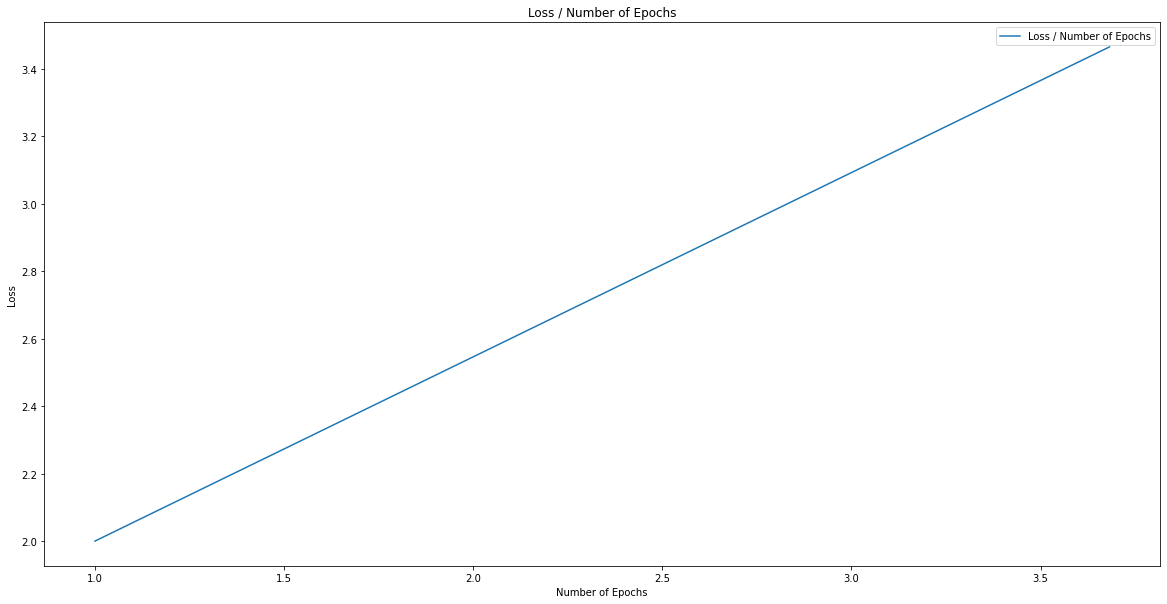

Train-Set: 
Accuracy: 9.30903721601396%
Test-Set: 
Accuracy: 9.369127516778523%




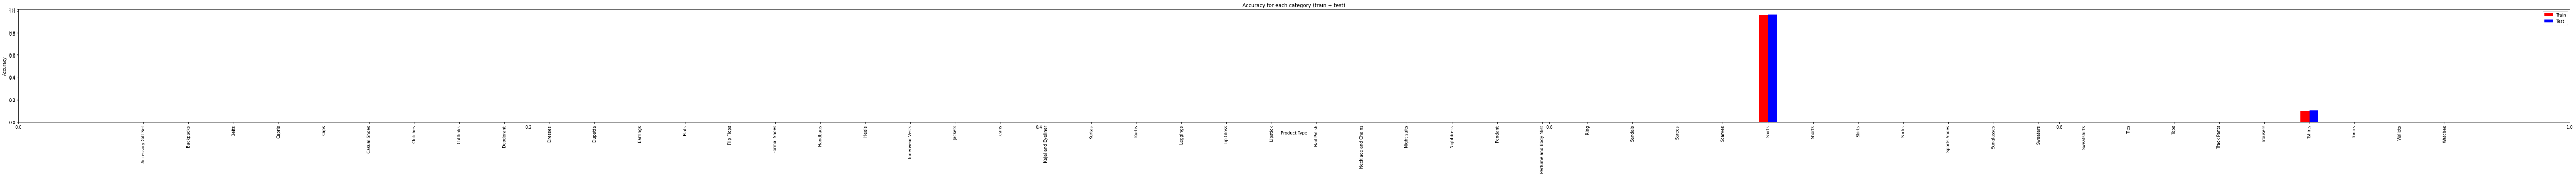

In [65]:
model = Model(len(classes))
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum = 0.5, weight_decay=0.1)

plot_loss_changes(fit(model, train_loader, device, criterion, optimizer, num_epochs=10))
plot_train_test_accuracies(class_accuracy(model,train_loader) , class_accuracy(model,test_loader) , classes)

print('Train-Set: ')
model_accuracy(model, train_loader)
print('Test-Set: ')
model_accuracy(model, test_loader)
print("\n")

### D - Weight Decay = 0.01

epoch 1, train_loss: 3.319, time elapsed: 14.237598 seconds
epoch 2, train_loss: 2.745, time elapsed: 14.216027 seconds
epoch 3, train_loss: 2.514, time elapsed: 14.166562 seconds
epoch 4, train_loss: 2.330, time elapsed: 14.177293 seconds
epoch 5, train_loss: 2.229, time elapsed: 14.237265 seconds
epoch 6, train_loss: 2.126, time elapsed: 14.178399 seconds
epoch 7, train_loss: 2.082, time elapsed: 13.745283 seconds
epoch 8, train_loss: 2.051, time elapsed: 13.902904 seconds
epoch 9, train_loss: 1.997, time elapsed: 13.794666 seconds
epoch 10, train_loss: 1.948, time elapsed: 13.918776 seconds
total training time: 2.343 minutes


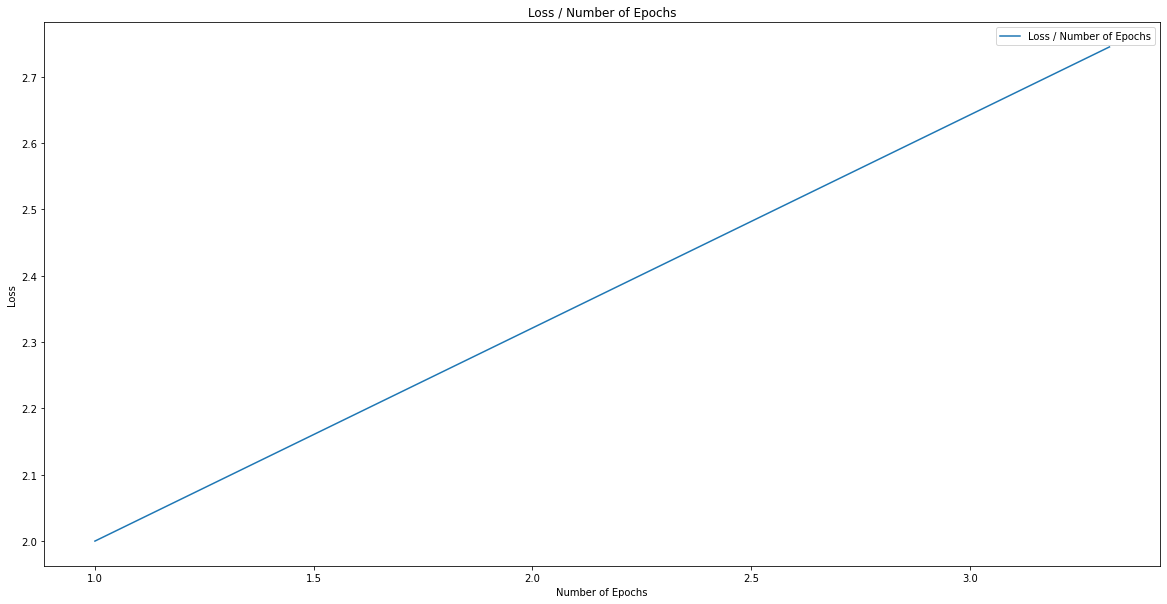

Train-Set: 
Accuracy: 38.20933588375449%
Test-Set: 
Accuracy: 38.33557046979866%




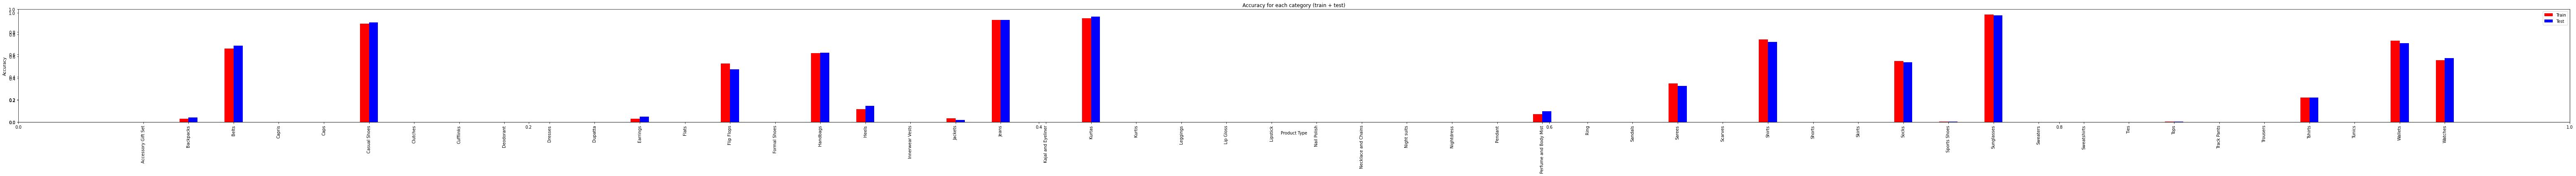

In [66]:
model = Model(len(classes))
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum = 0.5, weight_decay=0.01)

plot_loss_changes(fit(model, train_loader, device, criterion, optimizer, num_epochs=10))
plot_train_test_accuracies(class_accuracy(model,train_loader) , class_accuracy(model,test_loader) , classes)

print('Train-Set: ')
model_accuracy(model, train_loader)
print('Test-Set: ')
model_accuracy(model, test_loader)
print("\n")

As indicated from the results of two parts above, if we penalize the model complexity in large amount of numbers ( like the 11-C part ), the model will be so simple to be a good model and can not predict 52 classes efficiently. <br> This means our models are underfitted and are not as good as before. Here for better accuracies (like previous sections), we can reduce the weight_decay to even less number.